# Load the data

In [4]:
import pandas as pd

# Load the Excel file
excel_file = 'EMC.xlsx'

# Read all sheets into a dictionary of DataFrames
data = pd.read_excel(excel_file, sheet_name='Dataset')
print(data.head()) 

print(data.info())
print(data.isnull().sum())
 # 'sheet_name=None' loads all sheets

      id DCP_activation_date DCP_start_date  DCP_start_date_year  \
0  67330          2019-08-20     2019-08-30                 2019   
1  69260          2020-10-15     2020-11-15                 2020   
2  72183          2022-03-21     2022-04-24                 2022   
3  69494          2022-03-12     2022-04-24                 2022   
4  67603          2023-02-02     2023-02-24                 2023   

   DCP_start_date_month  date between activate and start  duration_of_dcp  \
0                     8                               10               48   
1                    11                               31               38   
2                     4                               34               29   
3                     4                               43               22   
4                     2                               22                8   

  DCP_drop_date        DCP_drop_status gender_at_activation  ... pmtstatus03  \
0    2023-08-09  Successful Completion          

# define target variable

In [5]:
# Create a binary column, 1 for "Successful", 0 for any other status
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)

print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 47 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id                                    3212 non-null   int64         
 1   DCP_activation_date                   3212 non-null   datetime64[ns]
 2   DCP_start_date                        3212 non-null   datetime64[ns]
 3   DCP_start_date_year                   3212 non-null   int64         
 4   DCP_start_date_month                  3212 non-null   int64         
 5   date between activate and start       3212 non-null   int64         
 6   duration_of_dcp                       3212 non-null   int64         
 7   DCP_drop_date                         3212 non-null   datetime64[ns]
 8   DCP_drop_status                       3212 non-null   object        
 9   gender_at_activation                  3212 non-null   object        
 10  

# Call LLM to categorize occupation_at_activation

In [45]:

data['occupation_at_activation'] = data['occupation_at_activation'].fillna('Unemployed')
occupations = data['occupation_at_activation']



In [ ]:
import requests
import json


def get_llm_categories_via_openrouter(occupations, api_key, timeout=30):
    """
    Send occupations to OpenRouter's LLM API to get high-level categories in JSON format.
    """
    # Format the prompt
    prompt = f"""
    Group the following occupations into logical categories. Every occupation in the list must be categorized without exception, even if the categorization is not 100% accurate. Do not omit, deduplicate, or summarize any entry. 

    Return the output in **strict JSON format**, where the keys are the category names, and the values are lists of occupations. Do not include explanations, comments, or representative examples—categorize every occupation explicitly.

    Example format:
    {{
        "Healthcare": ["Nurse", "Doctor"],
        "Transportation": ["Truck Driver", "Delivery Driver"],
        "Education": ["Teacher", "Professor"],
        "Unemployed": ["Unemployed", "None"]
    }}

    Here are the occupations:
    {occupations}
    """

    # Define headers and payload
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "anthropic/claude-3.5-sonnet:beta",  # Replace with the desired model
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0
    }

    # Send the API request
    response = requests.post(
        "https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        json=payload,
        timeout=timeout,
        
    )
    response.raise_for_status()  # Raise exception for HTTP errors
    response_data = response.json()
    return response_data.get('choices', [{}])[0].get('message', {}).get('content', "")

def process_in_batches(occupations, batch_size, api_key):
    """
    Process occupations in batches to avoid context window limits and categorize all occupations.
    """
    # Split occupations into batches
    def split_into_batches(data, size):
        for i in range(0, len(data), size):
            yield data[i:i + size]
    
    all_categories = {}
    
    for batch in split_into_batches(occupations, batch_size):
        # Format the batch for LLM processing
        formatted_occupations = "\n".join(f"- {occupation}" for occupation in batch)
        
        # Call the LLM for categorization
        llm_response = get_llm_categories_via_openrouter(formatted_occupations, api_key)
        
        # Extract JSON from response
        try:
            categories_dict = json.loads(llm_response)
        except json.JSONDecodeError:
            print(f"Invalid JSON response for batch: {llm_response}")
            continue
        
        # Merge results into all_categories
        for category, batch_occupations in categories_dict.items():
            all_categories.setdefault(category, []).extend(batch_occupations)
    
    return all_categories


# Save the response to a variable
api_key = "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"  # Replace with your actual OpenRouter API key
batch_size = 100  # Adjust based on the LLM's token/context limit

categories = process_in_batches(occupations, batch_size, api_key)


In [57]:
# Step 1: Create Reverse Mapping from `categories`
def create_reverse_mapping(categories):
    """
    Create a reverse mapping of occupation to category from the categories dictionary.
    """
    reverse_mapping = {}
    for category, occupations in categories.items():
        for occupation in occupations:
            reverse_mapping[occupation.strip()] = category
    return reverse_mapping

occupation_to_category = create_reverse_mapping(categories)

# Step 2: Map Categories to the DataFrame
def map_occupations_to_categories(data, reverse_mapping):
    """
    Map occupations in the DataFrame to categories based on reverse mapping.
    """
    data['occupation_category'] = data['occupation_at_activation'].map(reverse_mapping).fillna('Unmapped')
    return data

# Apply the mapping
data = map_occupations_to_categories(data, occupation_to_category)

# Step 3: Check the Result
print(data[['occupation_at_activation', 'occupation_category']])

     occupation_at_activation           occupation_category
0      truck driver (on WSIB)                Transportation
1                    DR PATAL                    Healthcare
2                 Housekeeper        Miscellaneous Services
3           PACKING ASSISTANT     Warehouse & Manufacturing
4                         PSW       Healthcare and Wellness
...                       ...                           ...
3207                   DRIVER  Transportation and Logistics
3208               Unemployed       Unemployment/Disability
3209                     Crew            Labor/General Work
3210           General Helper            Labor/General Work
3211             BOILER MAKER                 Manufacturing

[3212 rows x 2 columns]


In [87]:
# Check for unmapped occupations
num_unmapped = data[data['occupation_category'] == 'Unmapped'].shape[0]

# Print the result
print(f"Number of unmapped occupations: {num_unmapped}")


Number of unmapped occupations: 0


In [91]:
# Save the DataFrame to a CSV file
data.to_csv('occupation_mapped.csv', index=False)

# Feature engineering

In [92]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_data(data):
    # Create a copy
    df_processed = data.copy()
    
    # 1. Drop unnecessary columns
    # 1. Drop unnecessary columns and leakage columns
    columns_to_drop = [
        'pmtstatus01', 'pmtstatus02', 'pmtstatus03', 'pmtstatus04', 
        'pmtstatus05', 'pmtstatus06', 'pmtstatus07', 'pmtstatus08', 
        'pmtstatus09', 'pmtstatus10', 'pmtstatus11', 'pmtstatus12',
        'id', 'DCP_drop_status',
        'DCP_activation_date', 'DCP_start_date', 'DCP_drop_date',
        'DCP_start_date_year', 'DCP_start_date_month',
        'postal_prefix_at_activation',
        'duration_of_dcp',  # This might also be leakage if it's the total duration
        'occupation_at_activation'
    ]
    
    df_processed = df_processed.drop(columns=columns_to_drop)
    
    # 2. Separate features and target
    X = df_processed.drop('target', axis=1)
    y = df_processed['target']
    
    # 3. Define column types
    onehot_cols = [
        'gender_at_activation',
        'marital_status_at_activation',
        'housing_status_at_activation',
        'employment_status_at_activation',
       # 'city_at_activation',
        'reason_for_DCP_at_activation',
      #  'province_at_activation',
       # 'occupation_at_activation',
       'occupation_category'
    ]
    
    label_cols = [
        'city_at_activation',
        'province_at_activation',
       # 'occupation_at_activation',
    ]

    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # 4. Handle missing values and label encoding for high-cardinality categories
    
    for col in label_cols:
        # Fill missing values first
        X[col] = X[col].fillna('Unknown')
        # Apply label encoding
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    # 5. Create preprocessing steps for numerical and one-hot columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    # 6. Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, onehot_cols)
        ])
    
    # 7. Fit and transform the data
    X_transformed = preprocessor.fit_transform(X)
    
    # Get feature names
    onehot_features = []
    for i, col in enumerate(onehot_cols):
        categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[i][1:]
        onehot_features.extend([f"{col}_{cat}" for cat in categories])
    
    # Combine all feature names
    feature_names = numerical_cols + onehot_features
    
    # 8. Create final transformed dataset
    X_final = np.column_stack([
        X_transformed,
    #    X[label_cols].values
    ])
    
    # 9. Create DataFrame with feature names
    X_transformed_df = pd.DataFrame(X_final, columns=feature_names)
    
    # 10. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_transformed_df, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, feature_names

# Apply preprocessing
X_train, X_test, y_train, y_test, feature_names = preprocess_data(data)

# Print information about the transformed dataset
print(f"Number of features after encoding: {len(feature_names)}")
print("\nFeature types:")
print("Numerical features:", len([col for col in feature_names if not ('_' in col or col in ['postal_prefix_at_activation', 'city_at_activation', 'province_at_activation'])]))
print("Label encoded features:", len(['postal_prefix_at_activation', 'city_at_activation', 'province_at_activation']))
print("One-hot encoded features:", len([col for col in feature_names if '_' in col]))
print("\nSample of feature names:")
print(feature_names[:10])

Number of features after encoding: 288

Feature types:
Numerical features: 1
Label encoded features: 3
One-hot encoded features: 287

Sample of feature names:
['date between activate and start', 'age_at_activation', 'dependents_at_activation', 'has_dependants', 'number_in_household_at_activation', 'asset_amount_owed_at_activation', 'asset_value_at_activation', 'net_asset_value', 'monthly_income_at_activation', 'monthly_expenses_at_activation']


# Logistic Regression with feature importance

Model Performance:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       391
           1       0.61      0.47      0.53       252

    accuracy                           0.67       643
   macro avg       0.66      0.64      0.64       643
weighted avg       0.67      0.67      0.66       643

ROC-AUC Score: 0.714

Cross-validation ROC-AUC scores: [0.71435156 0.70877761 0.71969408 0.70663557 0.73092869]
Average CV ROC-AUC: 0.716 (+/- 0.017)

Top 15 Most Important Features:
                                               Feature  Coefficient
180   occupation_category_Manufacturing and Industrial     1.537749
125             occupation_category_General Employment    -1.500523
134  occupation_category_Government Benefits/Assist...    -1.300064
280        occupation_category_Unemployment/Disability    -1.288034
194              occupation_category_Military/Veterans     1.241503
202                          occupation_category_Other    -1.22

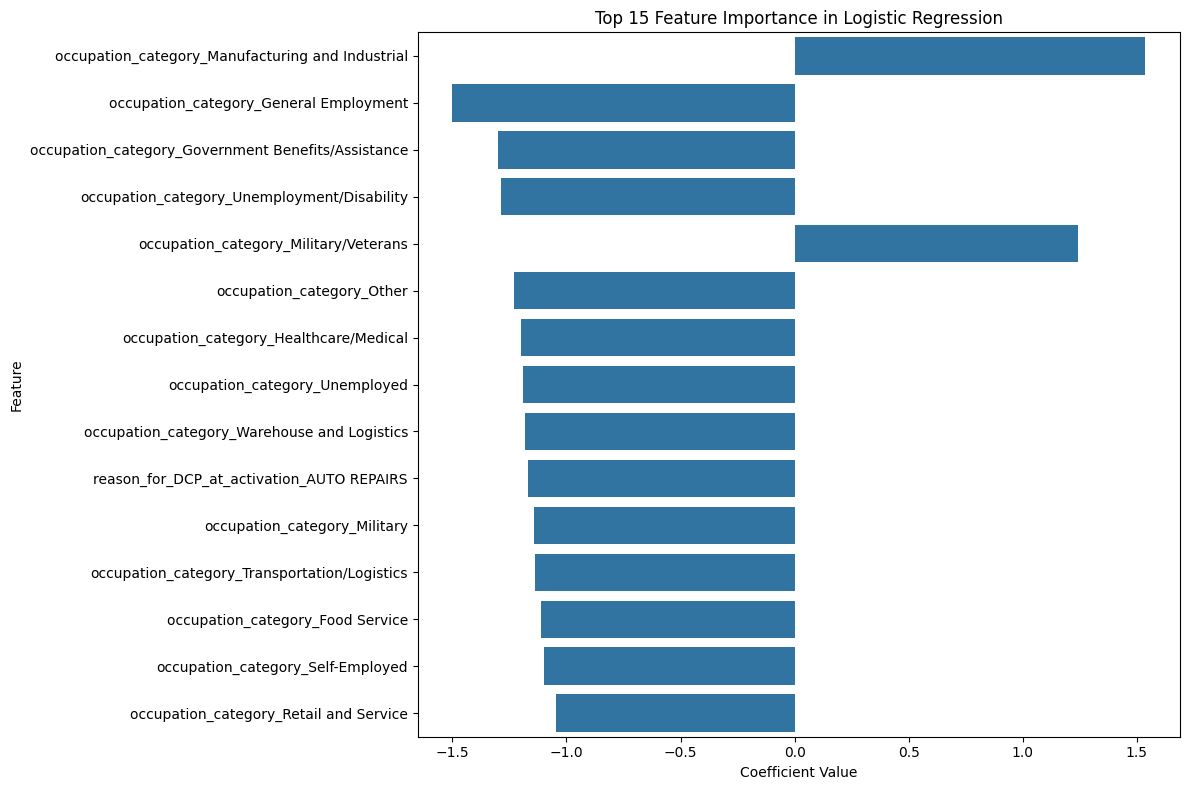

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fit Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# 2. Get model performance
y_pred = lr_model.predict(X_test)
print("Model Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]):.3f}")

# 3. Cross-validation scores
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC-AUC scores: {cv_scores}")
print(f"Average CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# 4. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Print top 15 most important features
print("\nTop 15 Most Important Features:")
print(feature_importance[['Feature', 'Coefficient']].head(15))

# 5. Visualize Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()



# Catboost

0:	learn: 0.6809878	total: 60.9ms	remaining: 30.4s
100:	learn: 0.4696089	total: 352ms	remaining: 1.39s
200:	learn: 0.3742583	total: 652ms	remaining: 969ms
300:	learn: 0.3040076	total: 944ms	remaining: 624ms
400:	learn: 0.2476307	total: 1.24s	remaining: 305ms
499:	learn: 0.2051278	total: 1.53s	remaining: 0us
Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       376
           1       0.62      0.51      0.56       267

    accuracy                           0.67       643
   macro avg       0.66      0.65      0.65       643
weighted avg       0.66      0.67      0.66       643

ROC-AUC Score: 0.72


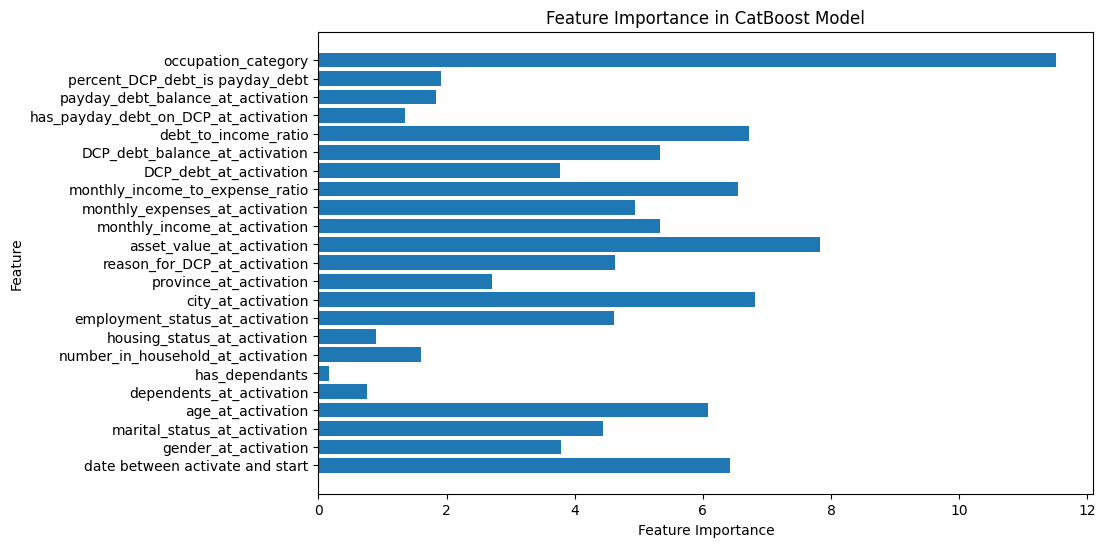

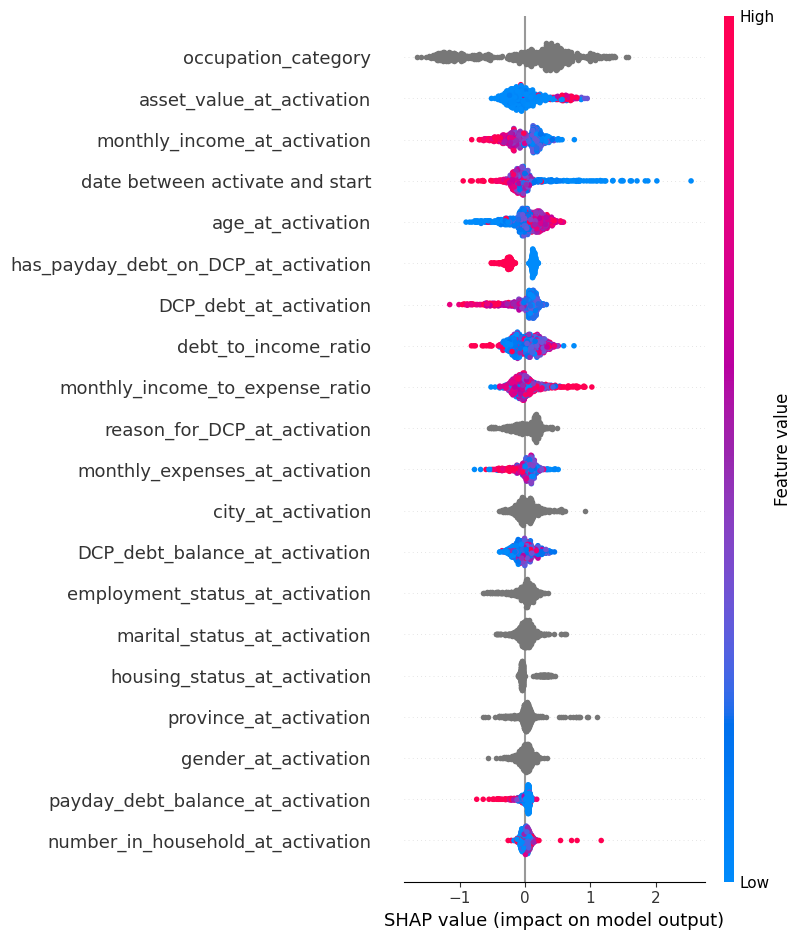

0:	learn: 0.6809878	total: 3.09ms	remaining: 1.54s
100:	learn: 0.4696089	total: 306ms	remaining: 1.21s
200:	learn: 0.3742583	total: 613ms	remaining: 911ms
300:	learn: 0.3040076	total: 913ms	remaining: 604ms
400:	learn: 0.2476307	total: 1.21s	remaining: 300ms
499:	learn: 0.2051278	total: 1.51s	remaining: 0us
Accuracy (using Pool): 0.67


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap

# Load the dataset
data = pd.read_csv('occupation_mapped.csv')

# Define target label
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)

# Drop irrelevant or leakage columns
columns_to_drop = [
    'pmtstatus01', 'pmtstatus02', 'pmtstatus03', 'pmtstatus04',
    'pmtstatus05', 'pmtstatus06', 'pmtstatus07', 'pmtstatus08',
    'pmtstatus09', 'pmtstatus10', 'pmtstatus11', 'pmtstatus12',
    'id', 'DCP_drop_status', 'DCP_activation_date', 'DCP_start_date',
    'DCP_drop_date', 'DCP_start_date_year', 'DCP_start_date_month',
    'postal_prefix_at_activation', 'asset_amount_owed_at_activation',
    'net_asset_value', 'duration_of_dcp', 'occupation_at_activation'
]
data = data.drop(columns=columns_to_drop)

# Handling Missing Values
# Fill missing numerical features with the median and categorical features with 'Unknown'
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna('Unknown', inplace=True)
    else:
        data[column].fillna(data[column].median(), inplace=True)

# Separate target variable (y) and features (X)
y = data['target']
X = data.drop(['target'], axis=1)  # Drop the target column from features

# Identify categorical and numerical columns
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype != 'object']

# Scale the numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CatBoost Model
catboost_model = CatBoostClassifier(
    iterations=500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate for training
    depth=6,  # Depth of each tree in the model
    cat_features=categorical_features,  # Specify which features are categorical
    verbose=100,  # Verbosity of training
    random_seed=42
)

# Fit the CatBoost Model
catboost_model.fit(X_train, y_train)

# Predict on the Test Set
y_pred = catboost_model.predict(X_test)

# Predict Probabilities for ROC-AUC Score
y_prob = catboost_model.predict_proba(X_test)[:, 1]

# Evaluate the Model
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_auc:.2f}')

# Feature Importance
feature_importances = catboost_model.get_feature_importance()
features = X.columns

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in CatBoost Model')
plt.show()

# SHAP Values for Detailed Interpretation
# Use SHAP to interpret feature importance
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

# Plot summary of feature importance using SHAP
shap.summary_plot(shap_values, X_test)

# Creating Pool object for CatBoost (Optional - improves efficiency)
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Re-fitting the model using Pool for efficiency
catboost_model.fit(train_pool)

# Predictions using Pool
predictions = catboost_model.predict(test_pool)

# Accuracy using Pool
accuracy_with_pool = accuracy_score(y_test, predictions)
print(f'Accuracy (using Pool): {accuracy_with_pool:.2f}')

# Next best action algorithm

In [4]:
single_record = X_test.iloc[0:1].copy()  # Select any specific record

baseline_prob = catboost_model.predict_proba(single_record)[:, 1][0]  # Baseline probability for the single record

probability_gains = {}
for feature in ['debt_to_income_ratio', 'monthly_income_to_expense_ratio',
                'monthly_expenses_at_activation', 'payday_debt_balance_at_activation',
                'DCP_debt_balance_at_activation']:
    # Adjust the single record
    single_record_adjusted = single_record.copy()
    if single_record_adjusted[feature].dtype != 'object' and len(single_record_adjusted[feature].unique()) > 2:
        single_record_adjusted[feature] += 1
    else:
        single_record_adjusted[feature] = 1
    
    # Recompute probability
    adjusted_prob = catboost_model.predict_proba(single_record_adjusted)[:, 1][0]
    probability_gains[feature] = adjusted_prob - baseline_prob  # Gain for the single record
    
nba_feature = max(probability_gains, key=probability_gains.get)
print(f"Next Best Action (NBA) Feature for Single Record: {nba_feature}")
print(f"Probability Gains for Single Record: {probability_gains}")



Next Best Action (NBA) Feature for Single Record: monthly_income_to_expense_ratio
Probability Gains for Single Record: {'debt_to_income_ratio': -0.012085925159919575, 'monthly_income_to_expense_ratio': 0.07369665769328093, 'monthly_expenses_at_activation': -0.031907968831391686, 'payday_debt_balance_at_activation': -0.03661021012531884, 'DCP_debt_balance_at_activation': -0.01714404978909201}


# xgboost

In [23]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Load data
data = pd.read_csv('occupation_mapped.csv')

# Define the target variable
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)

# Drop irrelevant columns
columns_to_drop = [
    'pmtstatus01', 'pmtstatus02', 'pmtstatus03', 'pmtstatus04',
    'pmtstatus05', 'pmtstatus06', 'pmtstatus07', 'pmtstatus08',
    'pmtstatus09', 'pmtstatus10', 'pmtstatus11', 'pmtstatus12',
    'id', 'DCP_drop_status', 'DCP_activation_date', 'DCP_start_date',
    'DCP_drop_date', 'DCP_start_date_year', 'DCP_start_date_month',
    'postal_prefix_at_activation', 'asset_amount_owed_at_activation',
    'net_asset_value', 'duration_of_dcp', 'occupation_at_activation'
]
data = data.drop(columns=columns_to_drop, errors='ignore')



# Handle missing values
data.fillna(0, inplace=True)  # Replace missing values with 0 (you can use other strategies)

# Separate features and target
X = data.drop(columns=['target'])
y = data['target']
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    enable_categorical=True  # Enable support for categorical data
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy:.2f}')
print(f'ROC-AUC Score: {roc_auc:.2f}')
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.63
ROC-AUC Score: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       376
           1       0.58      0.46      0.51       267

    accuracy                           0.63       643
   macro avg       0.62      0.61      0.61       643
weighted avg       0.63      0.63      0.63       643



# AutoML

In [26]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

# Step 1: Initialize H2O
h2o.init()

# Step 2: Load data
data = pd.read_csv('occupation_mapped.csv')
data['target'] = data['DCP_drop_status'].apply(lambda x: 1 if x == 'Successful Completion' else 0)

# Drop unnecessary columns
columns_to_drop = [
    'pmtstatus01', 'pmtstatus02', 'pmtstatus03', 'pmtstatus04',
    'pmtstatus05', 'pmtstatus06', 'pmtstatus07', 'pmtstatus08',
    'pmtstatus09', 'pmtstatus10', 'pmtstatus11', 'pmtstatus12',
    'id', 'DCP_drop_status', 'DCP_activation_date', 'DCP_start_date',
    'DCP_drop_date', 'DCP_start_date_year', 'DCP_start_date_month',
    'postal_prefix_at_activation', 'asset_amount_owed_at_activation',
    'net_asset_value', 'duration_of_dcp', 'occupation_at_activation'
]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Step 3: Convert to H2OFrame
h2o_data = h2o.H2OFrame(data)

# Step 4: Convert target to categorical
h2o_data['target'] = h2o_data['target'].asfactor()

# Step 5: Split data
train, test = h2o_data.split_frame(ratios=[0.8], seed=42)

# Step 6: Run AutoML
aml = H2OAutoML(
    max_runtime_secs=300,  # Allow 5 minutes
    max_models=20,         # Train up to 20 models
    seed=42,
    balance_classes=True,  # Handle class imbalance
    sort_metric="AUC"      # Optimize for AUC
)
aml.train(x=[col for col in h2o_data.columns if col != 'target'], y='target', training_frame=train)

# Step 7: View leaderboard
print(aml.leaderboard)

# Step 8: Make predictions
predictions = aml.leader.predict(test)
print(predictions.head())

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,14 mins 31 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_yuchenzhang_z41q8e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.75 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
20:45:04.268: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                           auc    logloss     aucpr    mean_per_class_error      rmse       mse
GLM_1_AutoML_10_20241128_204504               0.70056    0.603534  0.579969                0.359596  0.457048  0.208893
DRF_1_AutoML_10_20241128_204504               0.693092   0.625244  0.571512                0.365593  0.46458   0.215834
GBM_grid_1_AutoML_10_20241128_204504_model_3  0.672869   0.639431  0.546782                0.397475  0.471147  0.221979
GBM_grid_1_AutoML_10_20241128_204504_model_4  0.667228   0.653492  0.54203                 0.419508  0.475144  0.225762
XRT_1_AutoML_10_20241128_204504               0.665147   0.633477  0.540743                0.403346  0.470546  0.221413
GBM_3_AutoML_10_20241128_20